In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import joblib

In [2]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
TensorFlow built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.random.set_seed(42)

## Preprocessing Data

In [4]:
data = pd.read_csv("../data/processed/weatherQN_2021_2025_processed.csv", parse_dates=["time"])
data.set_index("time", inplace=True)
data.drop(columns='coco', inplace=True)

data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9
2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1
2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7
2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4
2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4


In [5]:
data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9
2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1
2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7
2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4
2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4


### Scaling data

In [6]:
scaler = StandardScaler()
features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']
data[features] = scaler.fit_transform(data[features])

In [7]:
data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,-1.768575,-2.174310,0.339529,-0.238048,1.359526,0.657297,1.693685
2021-01-02 03:00:00,-1.768575,-2.003564,0.505993,-0.033467,1.299386,0.362268,1.282513
2021-01-02 06:00:00,-1.825098,-2.003564,0.589225,-0.135758,1.265021,0.362268,1.419570
2021-01-02 09:00:00,-1.712052,-1.790130,0.672457,-0.033467,1.333752,0.487088,1.807900
2021-01-02 12:00:00,-1.203343,-1.918190,-0.243096,-0.135758,-1.621680,1.587774,1.351042


In [8]:
train_data = data.loc["2021":"2023"]
val_data = data.loc["2024-01":"2024-07"]
test_data = data.loc["2024-08":]

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 8746, Val size: 1704, Test size: 1681


## Prepare data in time step

In [9]:
def timestep_split(data, n_timestep=56, n_future=8): # 56 values of hours -> 7 days, 8 values of hours -> 1 day --> use 7 days to predict 1 day
    X, y = [], []
    for i in range(len(data) - n_timestep - n_future):
        X.append(data.iloc[i:i+n_timestep][features].values)
        y.append(data.iloc[i+n_timestep:i+n_timestep+n_future][features].values)
    return np.array(X), np.array(y)

In [10]:
X_train, y_train = timestep_split(train_data)
X_val, y_val = timestep_split(val_data)
X_test, y_test = timestep_split(test_data)

In [11]:
X_train[0][0]

array([-1.76857525, -2.17431041,  0.33952881, -0.23804783,  1.359526  ,
        0.65729739,  1.69368536])

In [12]:
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (8682, 56, 7), Val shape: (1640, 56, 7), Test shape: (1617, 56, 7)


In [13]:
# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

print("Shape X_train:", X_train_tensor.shape)
print("Shape y_train:", y_train_tensor.shape)

Shape X_train: (8682, 56, 7)
Shape y_train: (8682, 8, 7)


## Builidng models

In [14]:
best_model_path = '../models/best_forecast_model'

In [15]:
# Save Scaler
scaler_path = "../models/scalers/scaler.pkl"
joblib.dump(scaler, scaler_path)

['../models/scalers/scaler.pkl']

### LSTM Model

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), 
                                  input_shape=(56, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8 * len(features)),
    tf.keras.layers.Reshape((8, len(features))) 
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                   loss="mse", 
                   metrics=["mae"])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 56, 256)          139264    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 56, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 56, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [17]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
272/272 [==============================] - 19s 47ms/step - loss: 0.5630 - mae: 0.5083 - val_loss: 0.3073 - val_mae: 0.3968
Epoch 2/50
272/272 [==============================] - 14s 51ms/step - loss: 0.4051 - mae: 0.3996 - val_loss: 0.2631 - val_mae: 0.3574
Epoch 3/50
272/272 [==============================] - 7s 26ms/step - loss: 0.3721 - mae: 0.3749 - val_loss: 0.2351 - val_mae: 0.3335
Epoch 4/50
272/272 [==============================] - 7s 26ms/step - loss: 0.3508 - mae: 0.3587 - val_loss: 0.2271 - val_mae: 0.3244
Epoch 5/50
272/272 [==============================] - 7s 27ms/step - loss: 0.3340 - mae: 0.3482 - val_loss: 0.2594 - val_mae: 0.3429
Epoch 6/50
272/272 [==============================] - 7s 27ms/step - loss: 0.3264 - mae: 0.3439 - val_loss: 0.2236 - val_mae: 0.3237
Epoch 7/50
272/272 [==============================] - 7s 28ms/step - loss: 0.3201 - mae: 0.3399 - val_loss: 0.2241 - val_mae: 0.3173
Epoch 8/50
272/272 [==============================] - 8s 28ms/step 

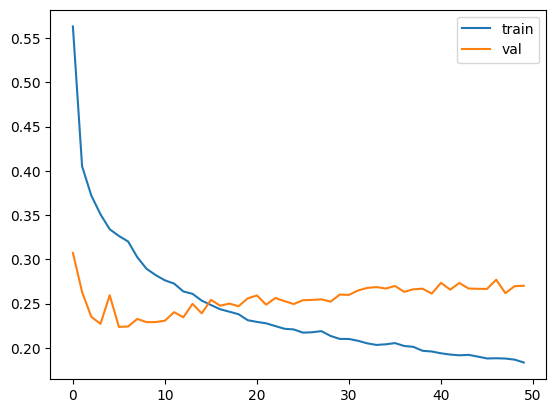

In [18]:
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='val')
plt.legend()
plt.show()

### GRU Model

In [ ]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True), 
                                  input_shape=(56, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8 * len(features)),
    tf.keras.layers.Reshape((8, len(features))) 
])

gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="mse", 
                  metrics=["mae"])

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 56, 256)          105216    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 56, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 56, 128)          123648    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 56, 128)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                      

In [20]:
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
272/272 [==============================] - 16s 40ms/step - loss: 0.4947 - mae: 0.4594 - val_loss: 0.2376 - val_mae: 0.3401
Epoch 2/50
272/272 [==============================] - 6s 24ms/step - loss: 0.3917 - mae: 0.3868 - val_loss: 0.2204 - val_mae: 0.3171
Epoch 3/50
272/272 [==============================] - 6s 24ms/step - loss: 0.3678 - mae: 0.3671 - val_loss: 0.2060 - val_mae: 0.3044
Epoch 4/50
272/272 [==============================] - 6s 24ms/step - loss: 0.3565 - mae: 0.3571 - val_loss: 0.2028 - val_mae: 0.3011
Epoch 5/50
272/272 [==============================] - 7s 25ms/step - loss: 0.3500 - mae: 0.3531 - val_loss: 0.2027 - val_mae: 0.2963
Epoch 6/50
272/272 [==============================] - 7s 25ms/step - loss: 0.3432 - mae: 0.3484 - val_loss: 0.2022 - val_mae: 0.3002
Epoch 7/50
272/272 [==============================] - 7s 24ms/step - loss: 0.3358 - mae: 0.3459 - val_loss: 0.2005 - val_mae: 0.2966
Epoch 8/50
272/272 [==============================] - 6s 24ms/step -

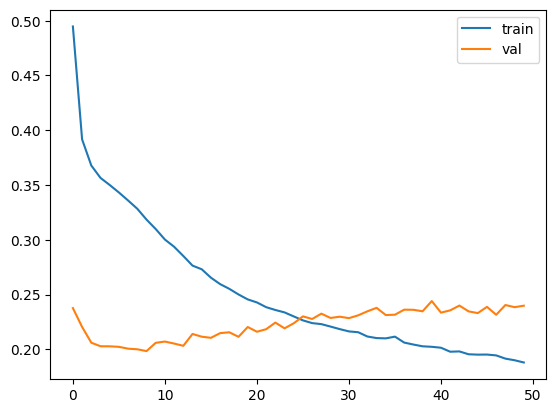

In [21]:
plt.plot(gru_history.history['loss'], label='train')
plt.plot(gru_history.history['val_loss'], label='val')
plt.legend()
plt.show()

### XGBoost Model

In [22]:
def create_xgboost_features(data, n_past=56, n_future=8):
    X, y = [], []
    for i in range(len(data) - n_past - n_future):
        past_data = data.iloc[i:i+n_past][features].values.flatten() 
        future_data = data.iloc[i+n_past:i+n_past+n_future][features].values.flatten()
        X.append(past_data)
        y.append(future_data)
    return np.array(X), np.array(y)

X_train_xgb, y_train_xgb = create_xgboost_features(train_data)
X_val_xgb, y_val_xgb = create_xgboost_features(val_data)
X_test_xgb, y_test_xgb = create_xgboost_features(test_data)

In [23]:
xgb_model = xgb.XGBRegressor(n_estimators=100, 
                             learning_rate=0.05, 
                             max_depth=6,
                             early_stopping_rounds=10)

xgb_model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=True)

[0]	validation_0-rmse:0.88818
[1]	validation_0-rmse:0.85599
[2]	validation_0-rmse:0.82537
[3]	validation_0-rmse:0.79687
[4]	validation_0-rmse:0.77013
[5]	validation_0-rmse:0.74517
[6]	validation_0-rmse:0.72195
[7]	validation_0-rmse:0.70019
[8]	validation_0-rmse:0.67992
[9]	validation_0-rmse:0.66101
[10]	validation_0-rmse:0.64347
[11]	validation_0-rmse:0.62724
[12]	validation_0-rmse:0.61219
[13]	validation_0-rmse:0.59816
[14]	validation_0-rmse:0.58508
[15]	validation_0-rmse:0.57308
[16]	validation_0-rmse:0.56200
[17]	validation_0-rmse:0.55181
[18]	validation_0-rmse:0.54228
[19]	validation_0-rmse:0.53363
[20]	validation_0-rmse:0.52553
[21]	validation_0-rmse:0.51805
[22]	validation_0-rmse:0.51125
[23]	validation_0-rmse:0.50498
[24]	validation_0-rmse:0.49919
[25]	validation_0-rmse:0.49387
[26]	validation_0-rmse:0.48901
[27]	validation_0-rmse:0.48458
[28]	validation_0-rmse:0.48046
[29]	validation_0-rmse:0.47666
[30]	validation_0-rmse:0.47313
[31]	validation_0-rmse:0.46990
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluate Model

In [24]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.reshape(-1, len(features)), y_pred.reshape(-1, len(features)))
    rmse = np.sqrt(mean_squared_error(y_test.reshape(-1, len(features)), y_pred.reshape(-1, len(features))))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse, y_pred

mae_lstm, rmse_lstm, y_pred_lstm = evaluate_model(lstm_model, X_test, y_test, "LSTM")
mae_gru, rmse_gru, y_pred_gru = evaluate_model(gru_model, X_test, y_test, "GRU")
mae_xgb, rmse_xgb, y_pred_xgb = evaluate_model(xgb_model, X_test_xgb, y_test_xgb, "XGBoost")

51/51 [==============================] - 4s 24ms/step
LSTM - MAE: 0.5447, RMSE: 0.8149
51/51 [==============================] - 3s 17ms/step
GRU - MAE: 0.5211, RMSE: 0.7824
XGBoost - MAE: 0.5757, RMSE: 2.4101


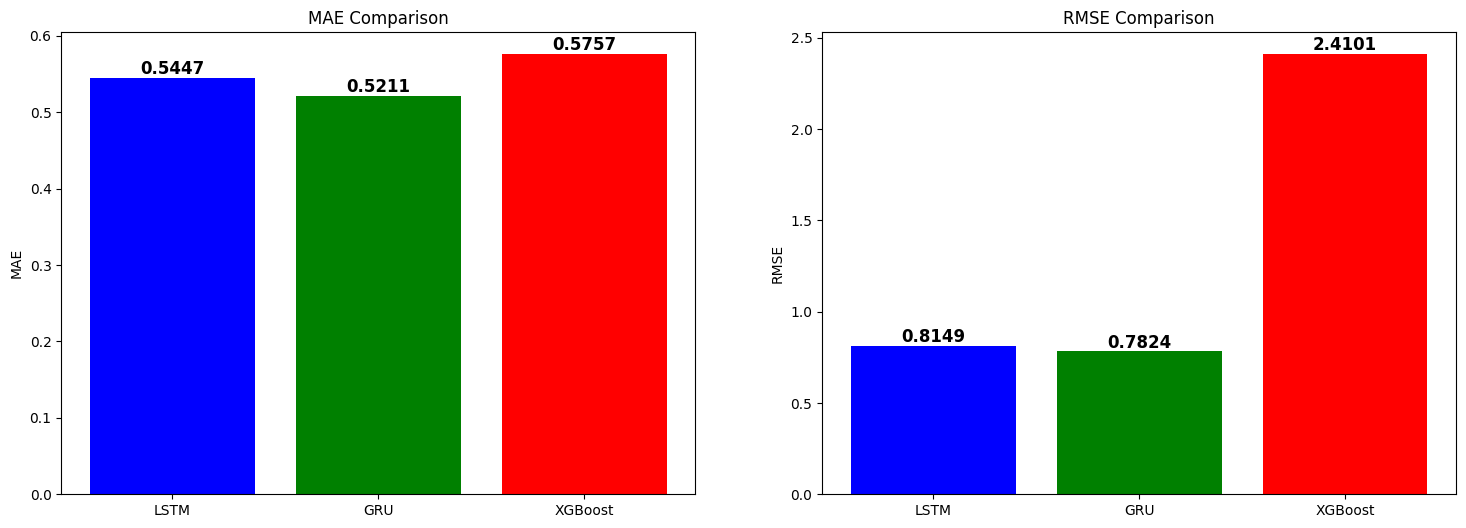

In [25]:
import matplotlib.pyplot as plt
import numpy as np

models = ["LSTM", "GRU", "XGBoost"]
mae_scores = [mae_lstm, mae_gru, mae_xgb]
rmse_scores = [rmse_lstm, rmse_gru, rmse_xgb]

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
bars1 = plt.bar(models, mae_scores, color=['blue', 'green', 'red'])
plt.title("MAE Comparison")
plt.ylabel("MAE")

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
bars2 = plt.bar(models, rmse_scores, color=['blue', 'green', 'red'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

|Model|MAE|RMSE|
|---|---|---|
|LSTM|0.5547|0.8149|
|GRU|0.5211|0.7824|
|XGBoost|0.5757|2.4101|

- GRU performs best, with the lowest error.
- LSTM is also good, but slightly worse than GRU.
- XGBoost has a very high RMSE, indicating large outliers.

--> GRU is the best choice for accuracy.

In [26]:
gru_model.save(best_model_path, save_format='tf')

INFO:tensorflow:Assets written to: ../models/best_forecast_model\assets


INFO:tensorflow:Assets written to: ../models/best_forecast_model\assets


In [28]:
if len(y_test_xgb.shape) == 2:
    y_test_xgb = y_test_xgb.reshape(-1, 8, len(features))

if len(y_pred_xgb.shape) == 2:
    y_pred_xgb = y_pred_xgb.reshape(-1, 8, len(features))

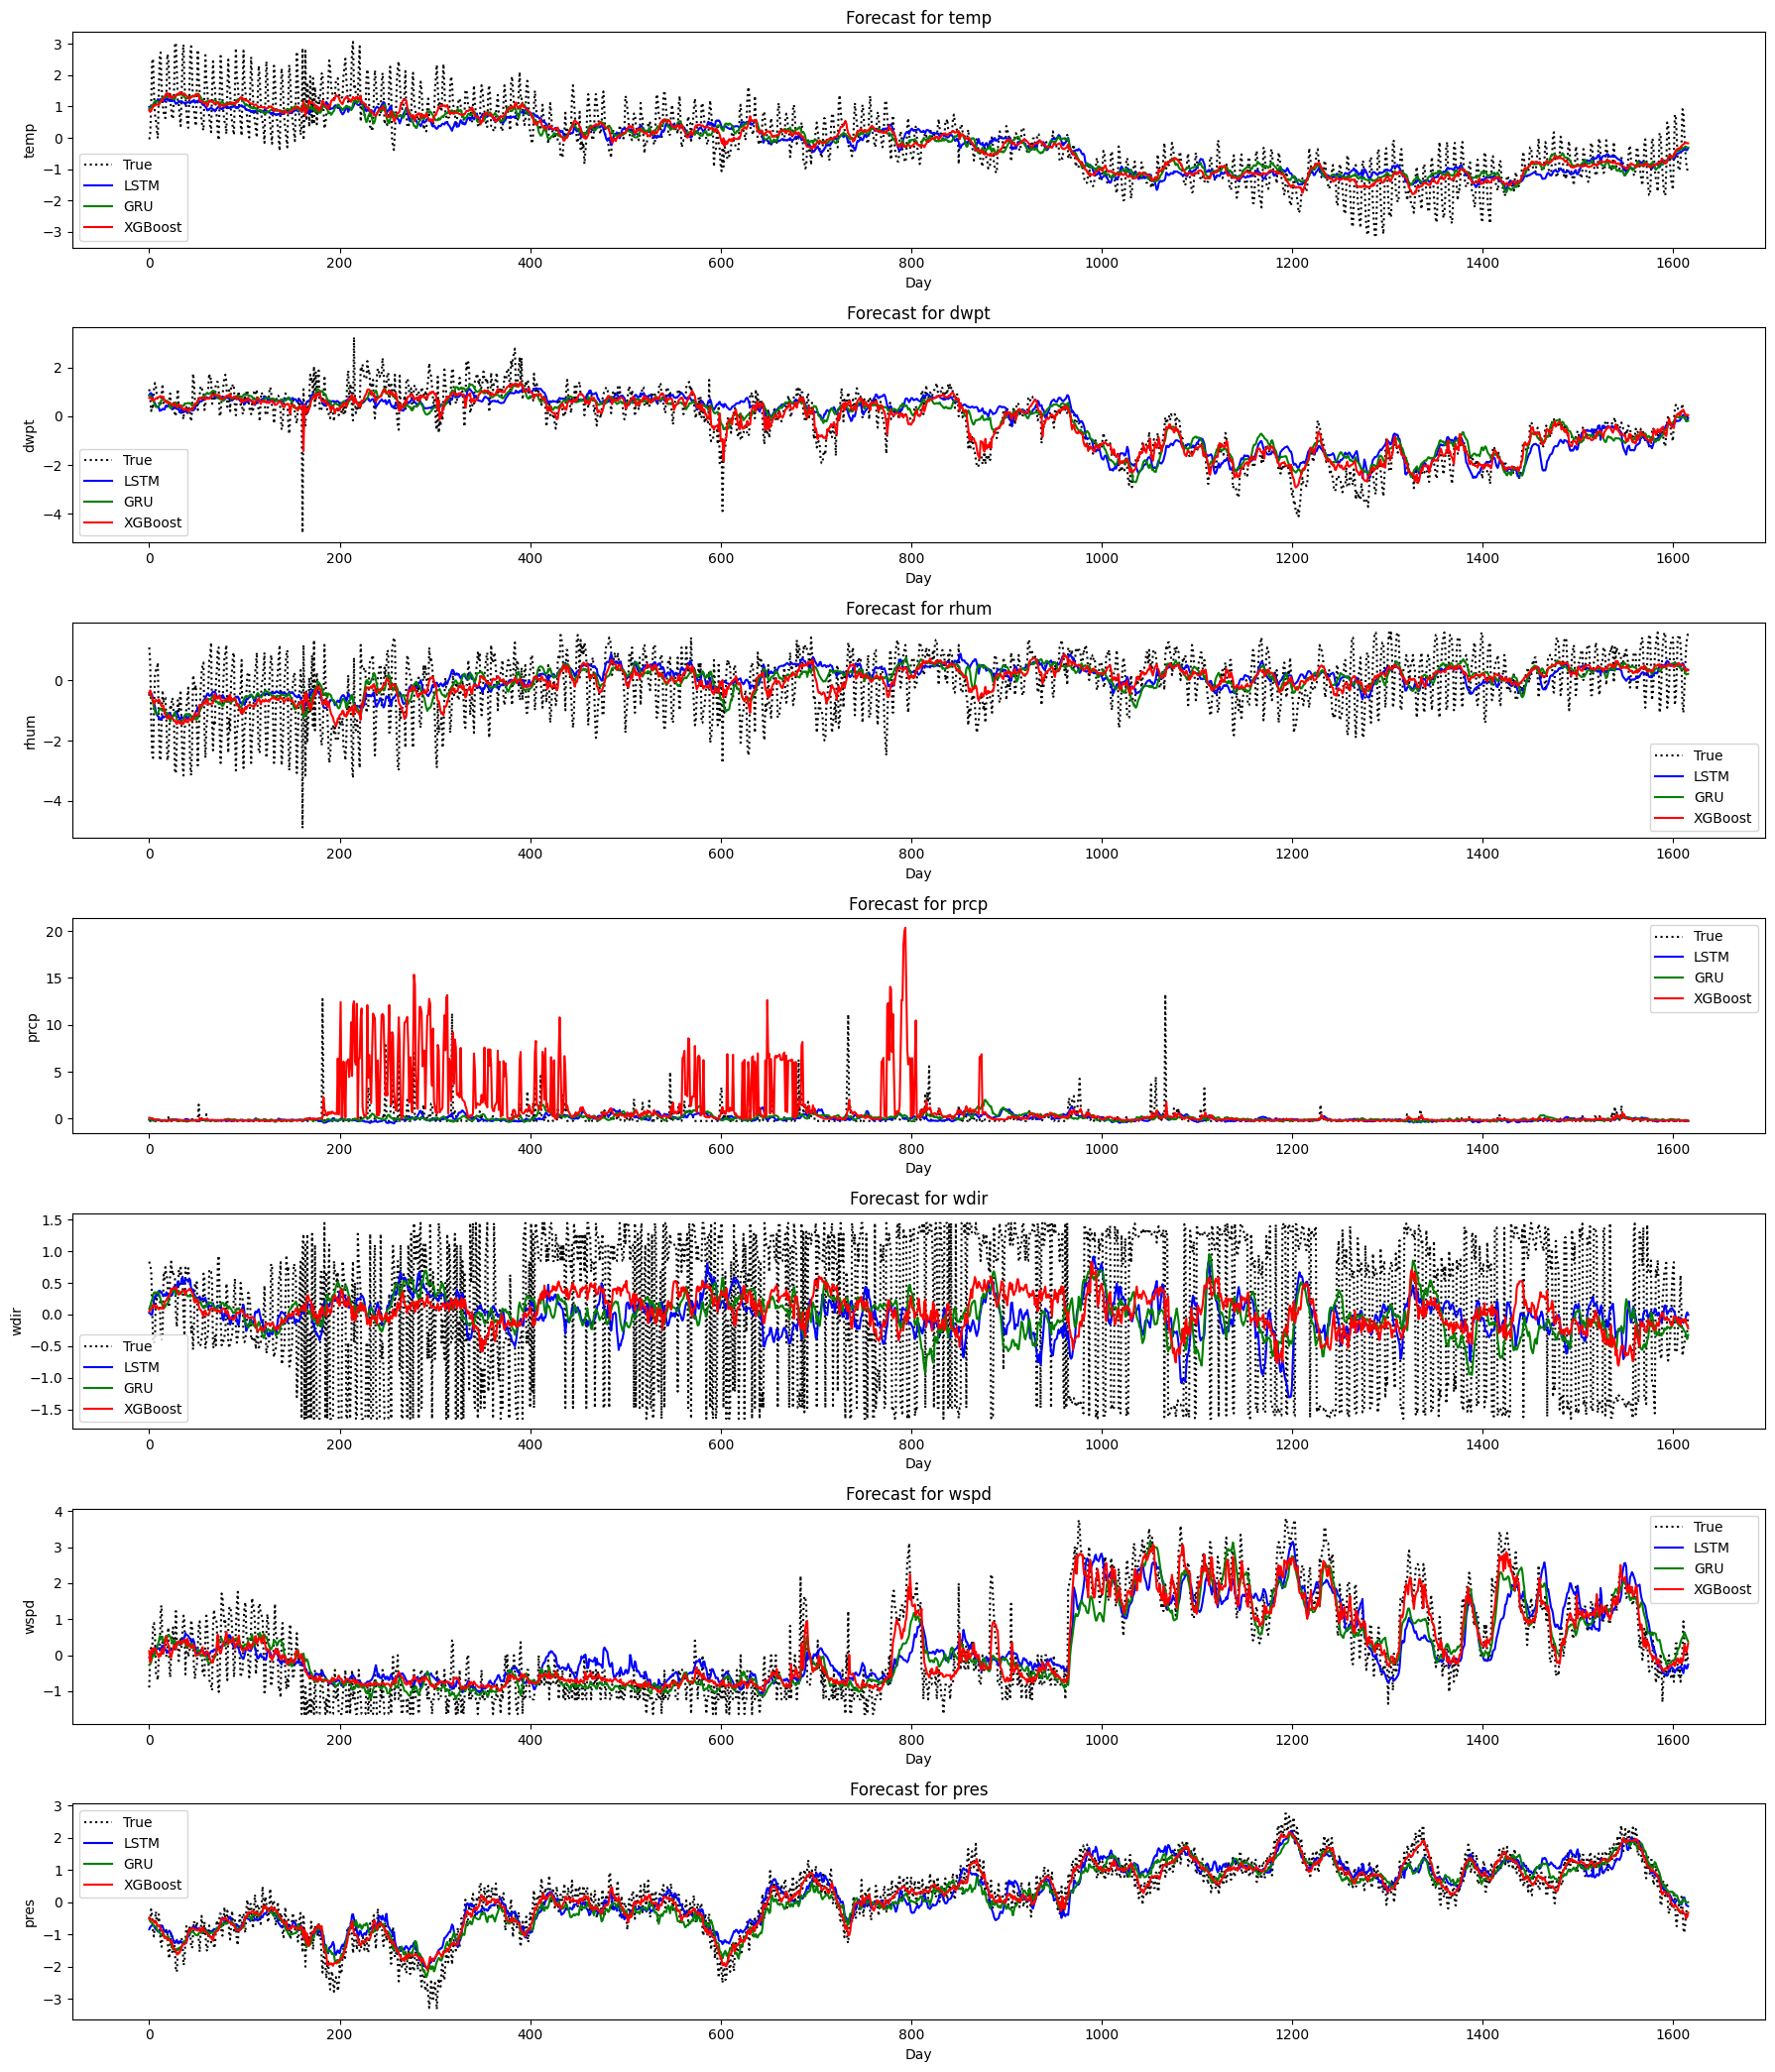

In [29]:
def plot_forecast_all_features(y_true, y_pred_lstm, y_pred_gru, y_pred_xgb, feature_names):
    num_features = len(feature_names)
    plt.figure(figsize=(18, 3 * num_features)) 

    for feature_idx in range(num_features):
        plt.subplot(num_features, 1, feature_idx + 1)

        y_pred_lstm_mean = y_pred_lstm[:, :, feature_idx].mean(axis=1)
        y_pred_gru_mean = y_pred_gru[:, :, feature_idx].mean(axis=1)
        y_pred_xgb_mean = y_pred_xgb[:, :, feature_idx].mean(axis=1)

        plt.plot(y_true[:, 0, feature_idx], label="True", color='black', linestyle="dotted")
        plt.plot(y_pred_lstm_mean, label="LSTM", color='blue')
        plt.plot(y_pred_gru_mean, label="GRU", color='green')
        plt.plot(y_pred_xgb_mean, label="XGBoost", color='red')

        plt.ylabel(feature_names[feature_idx])
        plt.xlabel("Day")

        plt.title(f"Forecast for {feature_names[feature_idx]}")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_forecast_all_features(y_test, y_pred_lstm, y_pred_gru, y_pred_xgb, features)

### Test model

In [78]:
y_pred = gru_model.predict(X_test)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

metrics = evaluate_model(y_test, y_pred)
print(metrics)

51/51 [==============================] - 1s 10ms/step
{'MSE': 0.6383802314810679, 'RMSE': 0.7989870033242518, 'MAE': 0.5343021264892435}


In [79]:
model = tf.keras.models.load_model(best_model_path)
scaler = joblib.load(scaler_path)

In [80]:
last_input = X_test[-1] 
last_input = np.expand_dims(last_input, axis=0)

In [81]:
num_future_steps = 56  # next 7 days
predictions = []

for _ in range(num_future_steps // 8):  
    pred = model.predict(last_input) 
    predictions.append(pred)

    last_input = np.concatenate([last_input[:, 8:, :], pred], axis=1)

predictions = np.concatenate(predictions, axis=1) 

1/1 [==============================] - 0s 23ms/step


In [82]:
predictions_original = scaler.inverse_transform(predictions.reshape(-1, len(features))).reshape(56, len(features))

In [83]:
future_dates = pd.date_range(data.index[-1] + pd.Timedelta(hours=3), periods=56, freq="3h")

In [84]:
df_predictions = pd.DataFrame(predictions_original, columns=features)

df_predictions.index = future_dates

df_predictions.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
2025-03-06 08:00:00,23.144676,22.642918,95.228561,0.145125,276.008606,12.902023,1008.343018
2025-03-06 11:00:00,25.319885,22.656923,85.176659,0.121637,215.581650,14.893388,1009.757996
2025-03-06 14:00:00,28.038286,22.596762,73.093063,0.147024,116.223267,19.632267,1009.407959
2025-03-06 17:00:00,28.184254,22.478542,72.000145,0.198637,72.037331,22.707476,1007.185242
2025-03-06 20:00:00,26.224497,22.521965,80.433891,0.148403,123.147278,20.968679,1006.888062


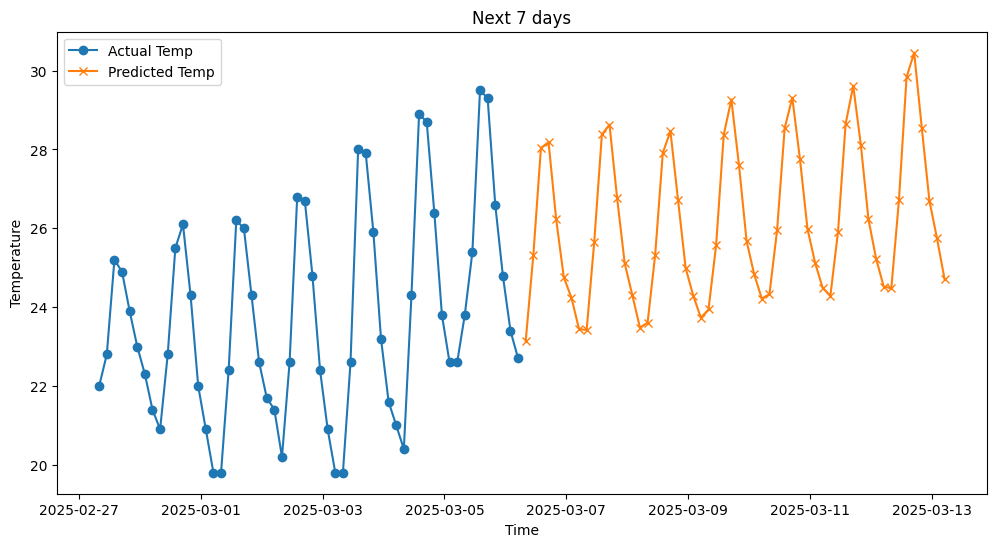

In [85]:
plt.figure(figsize=(12, 6))

plt.plot(data.index[-56:], scaler.inverse_transform(X_test[-1].reshape(-1, len(features)))[:, 0], label="Actual Temp", marker="o")

plt.plot(future_dates, predictions_original[:, 0], label="Predicted Temp", marker="x")

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Next 7 days")
plt.legend()
plt.show()